#Import Libraries

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import Dropout, BatchNormalization

from google.colab import drive

print("Module Loaded.")
print("TensorFlow Version :{}".format(tf.__version__))
print("NumPy Version :{}".format(np.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
TensorFlow Version :2.0.0
NumPy Version :1.17.4
Matplotlib Version :3.1.2


In [0]:
drive.mount('/content/drive')

data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data/furniture')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class_name = np.array([item.name for item in data_path.glob('*')])
print(class_name)

['rug' 'curtain' 'table' 'bed' 'bookshelves' 'sofa' 'makeup_table' 'chair'
 'standing_lamp' 'entertainment_center']


# Prepare Data

- **Unzip Data**

In [0]:
import os

cwd = os.getcwd()
print(cwd)

# !unzip /content/drive/Shared\ drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture.zip

/content


# Resize Image

In [0]:
# from PIL import Image

# for j in class_name[1:4]:
#     image = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data/furniture/'+j)
#     image = list(image.glob('*.jpg'))
#     for i in range(len(image)):
#         im = Image.open(str(image[i])).convert('RGB')
#         resize_image = im.resize((im.size[0]//2,im.size[1]//2))
#         resize_image.save('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture/{0}/{1}{2:03d}.jpg'.format(j,j,i))
#         print(j, i)

In [0]:
# data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture')

#ImageGenerator

In [0]:
img_size = 112
batch_n = 128

data_path = pathlib.Path('/content/furniture')

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #horizontal_flip=True, 
                                #vertical_flip=True,
                                #rotation_range=30,
                                zoom_range=0.1,
                                brightness_range=[0.8,1.2],
                                validation_split=0.2,
                                rescale=1./255)

In [0]:
train_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='training')
test_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='validation')

Found 3705 images belonging to 10 classes.
Found 921 images belonging to 10 classes.


#Load VGG

import model

In [0]:
import tensorflow.keras.applications.vgg16 as vgg16

model_vgg = vgg16.VGG16(
    weights="imagenet", 
    include_top=False,    # dense layer 이 후는 제외
    input_tensor=tf.keras.layers.Input(shape=(img_size, img_size, 3))
    #input_tensor=keras.layers.Input(shape=(49, 49, 3))
)

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

##fine tuning

freeze layers

In [0]:
# slicing which layers not to train
for layer in model_vgg.layers[:] :
  layer.trainable = False

for layer in model_vgg.layers :
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc04fd43ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fd43f60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fd9de10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc04ff32ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fd4f240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fcb99e8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc04fc47cc0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fc47da0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fc69550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc04fc73828> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc04fc04b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

make ai-kea model

In [0]:
ai_kea = tf.keras.models.Sequential()

ai_kea.add(model_vgg)

# Here add new layers
ai_kea.add(Flatten())
ai_kea.add(Dense(1024, activation='relu'))
#model_fine.add(keras.layers.Dropout(0.5))
#model_fine.add(keras.layers.LeakyReLU(alpha=0.1))
ai_kea.add(BatchNormalization())   # 필히 사용할 것
ai_kea.add(Dense(10, activation='softmax'))
ai_kea.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                10250     
Total params: 19,448,650
Trainable params: 4,731,914
Non-trainable params: 14,716,736
_________________________________________________________________


#model compile & train

In [0]:
epoch_n = 50

In [0]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch/epoch_n > 0.8:
        lr *= 0.5e-4
    elif epoch/epoch_n > 0.6:
        lr *= 1e-3
    elif epoch/epoch_n > 0.4:
        lr *= 1e-2
    elif epoch/epoch_n > 0.2:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule(0))
lrate = LearningRateScheduler(lr_schedule)
callbacks_list = [lrate]

Learning rate:  0.01


- **Compile**

In [0]:
ai_kea.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.01


- **Training**

In [0]:
# %%time
# # Run training, with or without data augmentation.
# data_augmentation = False

# if not data_augmentation:
#     print('Not using data augmentation.')
#     history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
#                   validation_data=(x_test, y_test), shuffle=True,
#                   callbacks=callbacks)
#     # Score trained model.
#     scores = model.evaluate(x_test, y_test, verbose=1)
#     print('Test loss:', scores[0])
#     print('Test accuracy:', scores[1])

In [0]:
history = ai_kea.fit_generator(
    train_data_generate,
    epochs = epoch_n,
    validation_data = test_data_generate,
    callbacks=callbacks_list
)

Learning rate:  0.01
Epoch 1/50
29/29 [==============================] - 39s 1s/step - loss: 0.3596 - accuracy: 0.8807 - val_loss: 1.2646 - val_accuracy: 0.7264
Learning rate:  0.01
Epoch 2/50
29/29 [==============================] - 31s 1s/step - loss: 0.3795 - accuracy: 0.8721 - val_loss: 2.1290 - val_accuracy: 0.6265
Learning rate:  0.01
Epoch 3/50
29/29 [==============================] - 31s 1s/step - loss: 0.3387 - accuracy: 0.8853 - val_loss: 1.0448 - val_accuracy: 0.7503
Learning rate:  0.01
Epoch 4/50
29/29 [==============================] - 31s 1s/step - loss: 0.3163 - accuracy: 0.8945 - val_loss: 1.3079 - val_accuracy: 0.7090
Learning rate:  0.01
Epoch 5/50
29/29 [==============================] - 31s 1s/step - loss: 0.2791 - accuracy: 0.9036 - val_loss: 1.3091 - val_accuracy: 0.7177
Learning rate:  0.01
Epoch 6/50
29/29 [==============================] - 32s 1s/step - loss: 0.2404 - accuracy: 0.9131 - val_loss: 1.2889 - val_accuracy: 0.7079
Learning rate:  0.01
Epoch 7/50
29

In [0]:
print(np.max(history.history['val_accuracy']))

0.7850163


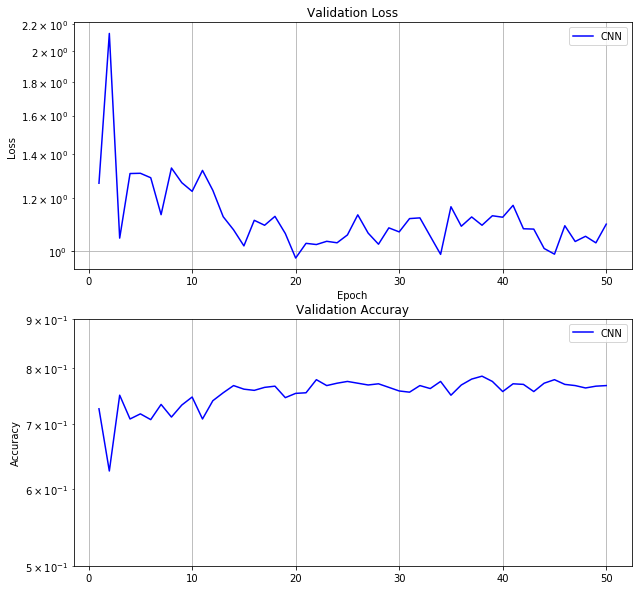

In [0]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.title('Validation Loss')
plt.semilogy(epochs, history.history['val_loss'], 'b', label='CNN')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.0, 0.6])
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Validation Accuray')
plt.semilogy(epochs, history.history['val_accuracy'], 'b', label='CNN')
plt.grid(True)
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.9])
plt.legend(loc='best')
plt.show()